In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import numpy as np
import math
from sklearn.utils import shuffle
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pickle
from kymatio.torch import Scattering1D
import pywt
import ipdb
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data

# CRASH_fname = 'CRASH_FE_filtered_subsampled_single.pkl'

# with open(CRASH_fname, 'rb') as handle:
#     F_t, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
#     inv_mapping, region_assignment, nTrain, nValid, \
#     nTest, scaler_in, scaler_out = pickle.load(handle)

eeg_mat = np.load('eeg_mat.npy')
eeg_mat.shape

(240, 189282, 61)

In [3]:
''' for calculating the coefficients (and save ... in 6 batches, each time 800)'''
seq_length = 5824
basic_len = 5824
eeg_idxer = np.arange(seq_length)[None, :] + np.arange(0, eeg_mat.shape[1] - seq_length + 1, basic_len)[:, None]
eeg_mat = eeg_mat[:,eeg_idxer,:]
eeg_mat = eeg_mat.transpose(0,3,1,2)
print(eeg_mat.shape)
eeg_mat = eeg_mat.reshape(-1, *eeg_mat.shape[2:])
print(eeg_mat.shape)

J = 7
Q = 12
scattering = Scattering1D(J, seq_length, Q)
batch_size = 100

eeg_mat = eeg_mat.reshape(-1, eeg_mat.shape[-1])
print(eeg_mat.shape)

(240, 61, 32, 5824)
(14640, 32, 5824)


In [5]:
coeffs = []
for batch_i in tqdm(range(1600,2400)): #tqdm(range(len(eeg_mat)//batch_size)): #4684
    cur_batch = eeg_mat[batch_i*batch_size:(batch_i+1)*batch_size]
    coeffs.append(scattering(torch.from_numpy(cur_batch).contiguous()))
    if batch_i % 200 == 0:
        with open('eeg_mat_coeff.pkl', 'wb') as handle:
            pickle.dump(coeffs, handle, protocol=pickle.HIGHEST_PROTOCOL)
# ipdb.set_trace()
np.save('eeg_mat_coeff3.npy', torch.cat(coeffs).cpu().numpy())

100%|██████████| 800/800 [31:55<00:00,  2.39s/it]


In [2]:
''' load calculated coeff and visualize'''
coeffs = np.load('eeg_mat_coeffs_J7Q12/eeg_mat_coeff1.npy')
print(coeffs.shape)

(80000, 251, 45)


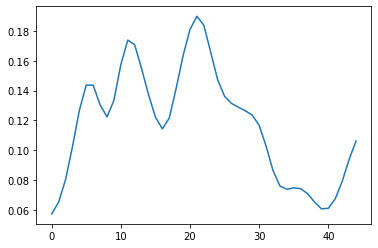

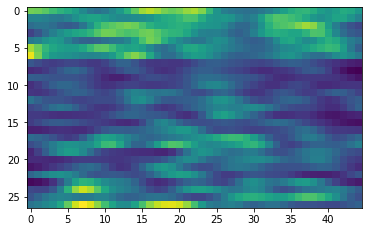

(27, 45)

In [12]:
plt.plot(coeffs[100][32])
plt.show()
plt.imshow(coeffs[0,32:59])
plt.show()

In [38]:
''' for loading the calculated eeg wavelet coefficients'''
coeffs = []
for i in tqdm(range(1,4)):
    coeffs.append(np.load('eeg_mat_coeffs_J7Q12/eeg_mat_coeff'+str(i)+'.npy')[:, 30:62])
coeffs = np.concatenate(coeffs)
print(coeffs.shape)
data = F.interpolate(torch.from_numpy(coeffs[:,None,...]), (32,32))
data.shape

100%|██████████| 3/3 [00:55<00:00, 18.60s/it]


(240000, 32, 45)


torch.Size([240000, 1, 32, 32])

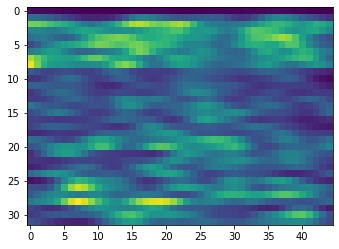

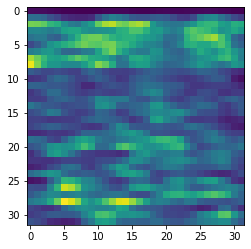

In [39]:
plt.imshow(coeffs[0])
plt.show()
plt.imshow(data[0,0])
plt.show()

In [43]:
idxer = np.arange(32)[None, :] + np.arange(0, 14640*32 - 32 + 1, 32)[:, None]
input_idxer = idxer[:,:-1]
label_idxer = idxer[:,1:]

print(input_idxer)
print(label_idxer)
print(input_idxer.flatten()[:50])
print(label_idxer.flatten()[:50])

print(label_idxer.flatten()[:232500].max()) # can have at most 232500 training pairs

input_idxer = input_idxer.flatten()[:232500]
label_idxer = label_idxer.flatten()[:232500]

[[     0      1      2 ...     28     29     30]
 [    32     33     34 ...     60     61     62]
 [    64     65     66 ...     92     93     94]
 ...
 [468384 468385 468386 ... 468412 468413 468414]
 [468416 468417 468418 ... 468444 468445 468446]
 [468448 468449 468450 ... 468476 468477 468478]]
[[     1      2      3 ...     29     30     31]
 [    33     34     35 ...     61     62     63]
 [    65     66     67 ...     93     94     95]
 ...
 [468385 468386 468387 ... 468413 468414 468415]
 [468417 468418 468419 ... 468445 468446 468447]
 [468449 468450 468451 ... 468477 468478 468479]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
239999


## same session, signals on different nodes

### kymatio

In [10]:
J = 7
Q = 12

base_len = 5824
node_num = 3

scattering = Scattering1D(J, base_len, Q)

sig = torch.from_numpy(eeg_mat[0,:base_len,:node_num]).transpose(0,1).contiguous()
coefs = scattering(sig)

print(coefs.shape)
print(scattering.meta()['order'])
order0, order1, order2 = (scattering.meta()['order']==0).sum(), (scattering.meta()['order']==1).sum(), (scattering.meta()['order']==2).sum()
print(order0, '0th order coef,', order1, '1st order coef,', order2, '2nd order coef.')

torch.Size([3, 251, 45])
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
1 0th order coef, 64 1st order coef, 186 2nd order coef.


plot signals


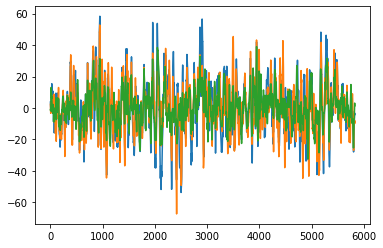

plot signals 0th coeffs


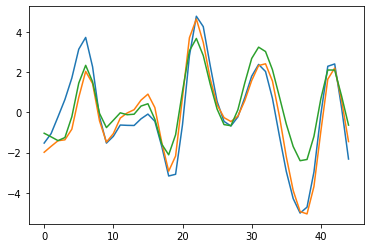

plot signals 1st coeffs


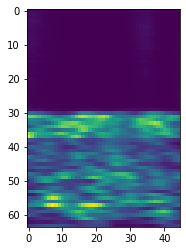

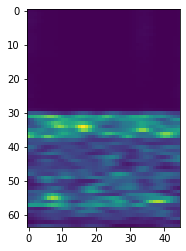

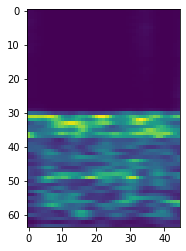

plot signals 1st coeffs


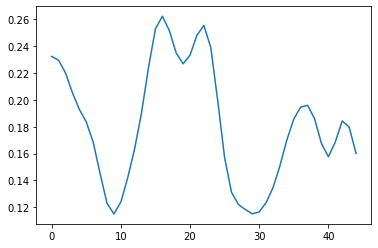

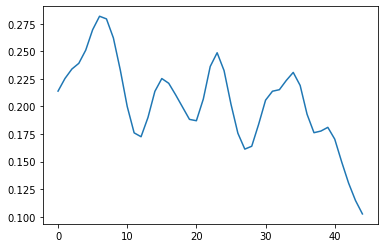

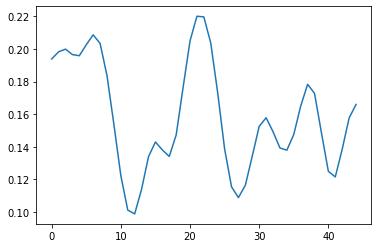

plot signals 2nd coeffs


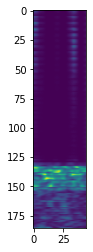

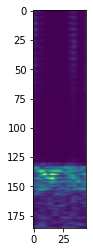

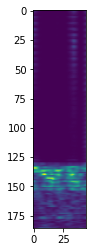

In [15]:
print('plot signals')
for i in range(node_num):
    plt.plot(sig[i])
plt.show()

# print('plot coeffs')
# for i in range(node_num):
#     plt.figure()
#     plt.imshow(coefs[i])
# plt.show()

print('plot signals 0th coeffs')
for i in range(node_num):
    plt.plot(coefs[i][0])
plt.show()

print('plot signals 1st coeffs')
for i in range(node_num):
    plt.figure()
    plt.imshow(coefs[i][order0:order0+order1])
plt.show()

# print('plot signals 1st coeffs')
# for i in range(node_num):
#     plt.figure()
#     plt.plot(coefs[i][32])
# plt.show()

print('plot signals 2nd coeffs')
for i in range(node_num):
    plt.figure()
    plt.imshow(coefs[i][order0+order1:])
plt.show()

In [21]:
proc_batch_size = 64
proc_eeg = torch.from_numpy(eeg_mat[:, :base_len, :].transpose(0,2,1).reshape(-1, base_len)).contiguous()

ret = []
for batch_i in tqdm(range(int(proc_eeg.shape[0]//proc_batch_size))):
    ret.append(scattering(proc_eeg[batch_i*proc_batch_size:(batch_i+1)*proc_batch_size]))

ret = torch.cat(ret)

100%|██████████| 228/228 [02:35<00:00,  1.46it/s]


In [25]:
torch.cat(ret).shape

torch.Size([14592, 177, 80])

### pytorch wavelet

Fast. But only has discrete for 1d

In [77]:
from pytorch_wavelets import DWT1DForward, DWT1DInverse

In [83]:
dwt = DWT1DForward(wave='db12', J=6)
c,f = dwt(x[None,None,:])

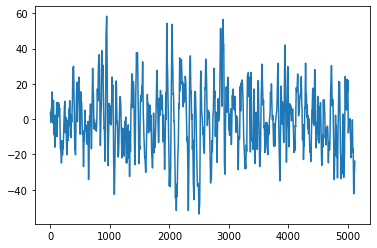

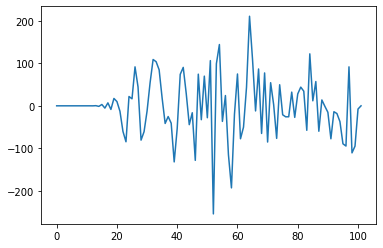

In [99]:
plt.plot(x)
plt.show()
plt.plot(c[0,0])

### pywt

The choice of mother wavelet & central frequency: Wavelets in Neuroscience (https://link.springer.com/book/10.1007/978-3-662-43850-3)P250: selection of mother wavelet. Complex Morlet seems the best for resting state signal  & P251: Morlet wavelet central frequency choose 2pi

Slow wave freq: 0.75 - 4Hz: https://www.sciencedirect.com/topics/medicine-and-dentistry/slow-brain-wave#:~:text=Slow-wave%20activity%20(SWA),the%200.75%E2%80%934.5%20Hz%20range.&text=SWA%20is%20defined%20as%20EEG,0.75%E2%80%934.5%20Hz%20for%20human.

So here scale up to a freq in between (~ 2.5)

In [107]:
pywt.scale2frequency('cmor6.2831852-3.1415926', np.arange(1,800)) * 640

array([2000.        , 1000.        ,  666.66666667,  500.        ,
        400.        ,  333.33333333,  285.71428571,  250.        ,
        222.22222222,  200.        ,  181.81818182,  166.66666667,
        153.84615385,  142.85714286,  133.33333333,  125.        ,
        117.64705882,  111.11111111,  105.26315789,  100.        ,
         95.23809524,   90.90909091,   86.95652174,   83.33333333,
         80.        ,   76.92307692,   74.07407407,   71.42857143,
         68.96551724,   66.66666667,   64.51612903,   62.5       ,
         60.60606061,   58.82352941,   57.14285714,   55.55555556,
         54.05405405,   52.63157895,   51.28205128,   50.        ,
         48.7804878 ,   47.61904762,   46.51162791,   45.45454545,
         44.44444444,   43.47826087,   42.55319149,   41.66666667,
         40.81632653,   40.        ,   39.21568627,   38.46153846,
         37.73584906,   37.03703704,   36.36363636,   35.71428571,
         35.0877193 ,   34.48275862,   33.89830508,   33.33333

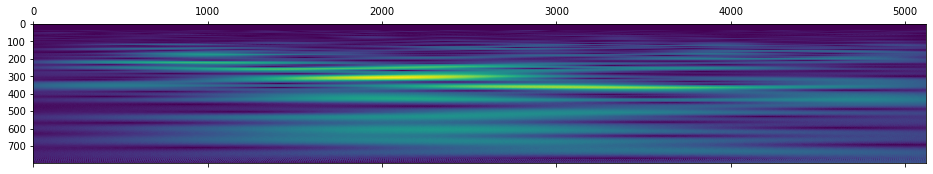

In [3]:
x = eeg_mat[0,:,0][:5120]
coef, f = pywt.cwt(x, np.arange(1,801), 'cmor6.2831852-3.1415926', 1.0/640)
plt.matshow(abs(coef))

### VAE model

In [44]:
'''from https://github.com/AntixK/PyTorch-VAE'''
class VanillaVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]#, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
        self.hidden_dims = hidden_dims

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[0], 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

device = 'cuda:0'
model = VanillaVAE(1,128).to(device)

### dealing with pywt data ...

torch.Size([2, 1, 64, 64])

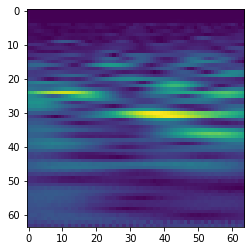

In [7]:
tmp = torch.tensor(abs(coef[None,None,...])).to(device)
tmp = F.interpolate(tmp, (64,64))
plt.imshow(tmp[0,0].cpu().numpy())
tmp = torch.cat((tmp, tmp))
tmp.shape

In [3]:
print(eeg_mat.shape)
basic_len = 5120
idxer = np.arange(basic_len)[None, :] + np.arange(0, eeg_mat.shape[1] - basic_len + 1, basic_len)[:, None]
data = eeg_mat[:, idxer, :]
del eeg_mat
print(data.shape)

# data = data.transpose(0,1,3,2)
# data = data.reshape(-1, data.shape[-1])
data = data[..., 5]
data = data.reshape(-1, data.shape[-1])

(240, 189282, 61)


(240, 36, 5120, 61)

In [25]:
coefs = []
for i in tqdm(range(len(data))):
    coef, f = pywt.cwt(data[i], np.arange(1,801), 'cmor6.2831852-3.1415926', 1.0/640)
    coefs.append(coef)

  0%|          | 0/240000 [00:00<?, ?it/s]


TypeError: Cannot convert torch.dtype to numpy.dtype

In [10]:
with open('eeg_coefs_:205.pkl', 'wb') as handle:
    pickle.dump(coefs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('eeg_coefs_:205.pkl', 'rb') as handle:
    data = pickle.load(handle)
data = abs(np.stack(data))[:,None,...]
data = F.interpolate(torch.from_numpy(data), (64,64))

### training

In [45]:
nTotal = len(data)
nTrain, nValid, nTest = int(nTotal * 0.7), int(nTotal * 0.15), int(nTotal * 0.15)

dTrain = data[:nTrain].to(device)
dVal = data[nTrain:nTrain+nValid].to(device)
dTest = data[-nTest:].to(device)

num_epoch = 50
batch_size = 32
lrate = 3e-3
wdecay = 4e-2


train_loss = []
val_loss = []

for e in range(num_epoch):
#     if e%50 == 0 and e>0:
#         lrate = lrate * 0.8
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    dTrain = shuffle(dTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_data = dTrain[i*batch_size:(i+1)*batch_size]
        res = model(batch_data)
        loss = model.loss_function(*res, M_N = batch_size/ nTrain)
        
        cur_loss.append(loss['loss'].item())
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
    
    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', train_loss[-1])
    
    model.eval()
    cur_loss = []
    for i in tqdm(range(nValid//batch_size)):
        batch_data = dVal[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            res = model(batch_data)
            loss = model.loss_function(*res, M_N = batch_size/ nValid)
        cur_loss.append(loss['loss'].item())
    val_loss.append(np.mean(cur_loss))
    print('val loss', val_loss[-1])
    
        

  2%|▏         | 21/1125 [00:00<00:05, 206.99it/s]

epoch 0 train loss 0.004513399705911676


  0%|          | 7/5250 [00:00<01:25, 61.04it/s]

val loss 0.0027042413242161275


  2%|▏         | 27/1125 [00:00<00:04, 265.74it/s]

epoch 1 train loss 0.0044788981968359575


  0%|          | 5/5250 [00:00<01:54, 45.69it/s]

val loss 0.0027073462013569144


  2%|▏         | 26/1125 [00:00<00:04, 252.88it/s]

epoch 2 train loss 0.004478829780660038


  0%|          | 7/5250 [00:00<01:22, 63.83it/s]

val loss 0.002717150752018723


  2%|▏         | 26/1125 [00:00<00:04, 252.50it/s]

epoch 3 train loss 0.004478085509368352


  0%|          | 7/5250 [00:00<01:22, 63.56it/s]

val loss 0.0027627248299411603


  2%|▏         | 26/1125 [00:00<00:04, 250.99it/s]

epoch 4 train loss 0.004478992951302124


  0%|          | 7/5250 [00:00<01:22, 63.61it/s]

val loss 0.0027016563137165373


  2%|▏         | 27/1125 [00:00<00:04, 262.41it/s]

epoch 5 train loss 0.004478972630508777


  0%|          | 7/5250 [00:00<01:22, 63.55it/s]

val loss 0.002768540064390335


  2%|▏         | 26/1125 [00:00<00:04, 252.60it/s]

epoch 6 train loss 0.004478952439014046


  0%|          | 7/5250 [00:00<01:22, 63.45it/s]

val loss 0.00278413616741697


  2%|▏         | 25/1125 [00:00<00:04, 233.03it/s]

epoch 7 train loss 0.004478494364546524


  0%|          | 7/5250 [00:00<01:22, 63.71it/s]

val loss 0.00276668767672446


  2%|▏         | 18/1125 [00:00<00:06, 176.38it/s]

epoch 8 train loss 0.0044781204283769645


  0%|          | 6/5250 [00:00<01:30, 58.16it/s]

val loss 0.0028068292446227537


  2%|▏         | 26/1125 [00:00<00:04, 252.07it/s]

epoch 9 train loss 0.004477967628632628


  0%|          | 7/5250 [00:00<01:22, 63.70it/s]

val loss 0.0028404747235278287


  2%|▏         | 26/1125 [00:00<00:04, 252.76it/s]

epoch 10 train loss 0.004478671514296106


  0%|          | 7/5250 [00:00<01:22, 63.58it/s]

val loss 0.002778774263958136


  2%|▏         | 18/1125 [00:00<00:06, 177.73it/s]

epoch 11 train loss 0.00447840466181792


  0%|          | 6/5250 [00:00<01:35, 54.79it/s]

val loss 0.0027591983538327947


  2%|▏         | 26/1125 [00:00<00:04, 250.90it/s]

epoch 12 train loss 0.004478592344515381


  0%|          | 7/5250 [00:00<01:22, 63.83it/s]

val loss 0.0027342050668473046


  2%|▏         | 26/1125 [00:00<00:04, 250.33it/s]

epoch 13 train loss 0.00447838706385699


  0%|          | 7/5250 [00:00<01:22, 63.82it/s]

val loss 0.002715754552123447


  2%|▏         | 26/1125 [00:00<00:04, 253.14it/s]

epoch 14 train loss 0.004478610313320089


  0%|          | 6/5250 [00:00<01:39, 52.80it/s]

val loss 0.002780151276021368


  2%|▏         | 26/1125 [00:00<00:04, 250.67it/s]

epoch 15 train loss 0.004479322144229497


  0%|          | 7/5250 [00:00<01:22, 63.49it/s]

val loss 0.0027677460867497655


  2%|▏         | 26/1125 [00:00<00:04, 250.19it/s]

epoch 16 train loss 0.004478900257409328


  0%|          | 7/5250 [00:00<01:22, 63.43it/s]

val loss 0.002742750101412336


  2%|▏         | 26/1125 [00:00<00:04, 253.45it/s]

epoch 17 train loss 0.0044786881513982305


  0%|          | 7/5250 [00:00<01:22, 63.72it/s]

val loss 0.0028056201778559223


  2%|▏         | 26/1125 [00:00<00:04, 253.12it/s]

epoch 18 train loss 0.004477879439480603


  0%|          | 7/5250 [00:00<01:22, 63.67it/s]

val loss 0.0027264145018739833


  2%|▏         | 26/1125 [00:00<00:04, 252.05it/s]

epoch 19 train loss 0.004478738311545125


  0%|          | 7/5250 [00:00<01:27, 60.20it/s]

val loss 0.002749496896647745


  2%|▏         | 26/1125 [00:00<00:04, 253.38it/s]

epoch 20 train loss 0.004478892520535737


  0%|          | 7/5250 [00:00<01:22, 63.69it/s]

val loss 0.0027182075285042324


  2%|▏         | 25/1125 [00:00<00:04, 248.76it/s]

epoch 21 train loss 0.004478929229479815


  0%|          | 4/5250 [00:00<02:32, 34.32it/s]

val loss 0.002709810245471696


  2%|▏         | 26/1125 [00:00<00:04, 252.57it/s]

epoch 22 train loss 0.004479516610392325


  0%|          | 7/5250 [00:00<01:22, 63.83it/s]

val loss 0.002729412525374856


  2%|▏         | 26/1125 [00:00<00:04, 252.19it/s]

epoch 23 train loss 0.0044784381966372685


  0%|          | 7/5250 [00:00<01:22, 63.60it/s]

val loss 0.00273923446269085


  2%|▏         | 18/1125 [00:00<00:06, 176.30it/s]

epoch 24 train loss 0.004478719399354997


  0%|          | 6/5250 [00:00<01:37, 53.83it/s]

val loss 0.0027439700820379785


  2%|▏         | 26/1125 [00:00<00:04, 252.56it/s]

epoch 25 train loss 0.004478945132367135


  0%|          | 7/5250 [00:00<01:22, 63.56it/s]

val loss 0.002760270428015954


  2%|▏         | 26/1125 [00:00<00:04, 251.86it/s]

epoch 26 train loss 0.004478135743799309


  0%|          | 7/5250 [00:00<01:22, 63.69it/s]

val loss 0.0027563984336124525


  2%|▏         | 27/1125 [00:00<00:04, 262.43it/s]

epoch 27 train loss 0.004478651891883818


  0%|          | 6/5250 [00:00<01:36, 54.34it/s]

val loss 0.002754226568258471


  2%|▏         | 26/1125 [00:00<00:04, 252.74it/s]

epoch 28 train loss 0.004478351186739192


  0%|          | 7/5250 [00:00<01:22, 63.74it/s]

val loss 0.0027683470407500865


  2%|▏         | 26/1125 [00:00<00:04, 250.75it/s]

epoch 29 train loss 0.004478768336409259


  0%|          | 7/5250 [00:00<01:23, 62.87it/s]

val loss 0.002770303463977244


  2%|▏         | 26/1125 [00:00<00:04, 253.17it/s]

epoch 30 train loss 0.004478687508807828


  0%|          | 7/5250 [00:00<01:22, 63.61it/s]

val loss 0.0027281281897384257


  2%|▏         | 24/1125 [00:00<00:04, 231.74it/s]

epoch 31 train loss 0.004478474070118474


  0%|          | 7/5250 [00:00<01:22, 63.47it/s]

val loss 0.002697066651036342


  2%|▏         | 26/1125 [00:00<00:04, 251.62it/s]

epoch 32 train loss 0.004479476200882345


  0%|          | 7/5250 [00:00<01:22, 63.65it/s]

val loss 0.002750237786831955


  2%|▏         | 26/1125 [00:00<00:04, 251.67it/s]

epoch 33 train loss 0.004479390600385765


  0%|          | 7/5250 [00:00<01:22, 63.84it/s]

val loss 0.0027197692392186986


  2%|▏         | 26/1125 [00:00<00:04, 252.25it/s]

epoch 34 train loss 0.004478748639424642


  0%|          | 7/5250 [00:00<01:22, 63.77it/s]

val loss 0.0027031562474245825


  2%|▏         | 26/1125 [00:00<00:04, 253.47it/s]

epoch 35 train loss 0.0044790443712845445


  0%|          | 7/5250 [00:00<01:22, 63.57it/s]

val loss 0.002766915526241064


  2%|▏         | 26/1125 [00:00<00:04, 252.72it/s]

epoch 36 train loss 0.004478930499094228


  0%|          | 7/5250 [00:00<01:22, 63.60it/s]

val loss 0.0027347839562636284


 82%|████████▏ | 4298/5250 [01:08<00:15, 63.06it/s]


KeyboardInterrupt: 

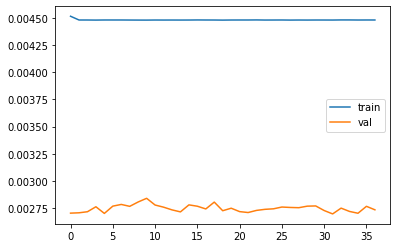

In [46]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [47]:
model.eval()
cur_loss = []
for i in tqdm(range(nTest//batch_size)):
    batch_data = dTest[i*batch_size:(i+1)*batch_size]
    with torch.no_grad():
        res = model(batch_data)
        loss = model.loss_function(*res, M_N = batch_size/ nTest)
    cur_loss.append(loss['loss'].item())
print(np.mean(cur_loss))

100%|██████████| 1125/1125 [00:05<00:00, 192.86it/s]

0.004665176167980664


In [48]:
test_out = res

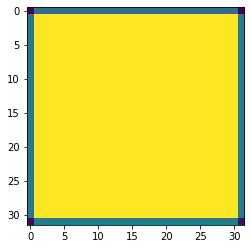

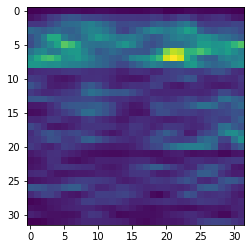

In [49]:
plt.imshow(test_out[0][10].detach().cpu().numpy().squeeze())
plt.show()
plt.imshow(test_out[1][10].detach().cpu().numpy().squeeze())
plt.show()

In [7]:
model.loss_function(*test_out, M_N = 1)

{'loss': tensor(120.0410, device='cuda:0'),
 'Reconstruction_Loss': tensor(120.0408, device='cuda:0'),
 'KLD': tensor(-0.0002, device='cuda:0')}